In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing Libraries
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from numpy import *

## Reading and Understanding the Data

In [3]:
# Reading the file
df_beer = pd.read_csv('beer_data.csv')

In [4]:
# Checking the head of the dataset
df_beer.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [5]:
# inspecting data and identifying total number of rows and for nulls in rows.
print(df_beer.shape)
print(df_beer.info())

(475984, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
beer_beerid           475984 non-null int64
review_profilename    475884 non-null object
review_overall        475984 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ MB
None


In [6]:
# Number of missing values in each column.
print(df_beer.isnull().sum())

# Getting the column-wise null percentage
round(100*(df_beer.isnull().sum()/len(df_beer.index)),2)  

beer_beerid             0
review_profilename    100
review_overall          0
dtype: int64


beer_beerid           0.00
review_profilename    0.02
review_overall        0.00
dtype: float64

## Data Cleaning & Preparation

In [7]:
# We can drop all rows having review_profilename = null as there are only 100 such rows which is less than 1% of total data.

# replacing the empty values with nan
df_beer['review_profilename'].replace('', np.nan, inplace=True)

# dropping the rows
df_beer.dropna(subset=['review_profilename'], inplace=True)

# 100 rows dropped
print(df_beer.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475884 entries, 0 to 475983
Data columns (total 3 columns):
beer_beerid           475884 non-null int64
review_profilename    475884 non-null object
review_overall        475884 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 14.5+ MB
None


In [8]:
# Now our dataset doesnt have any nulls. Lets check for duplicates
df_beer.nunique()

beer_beerid           40304
review_profilename    22497
review_overall           10
dtype: int64

In [9]:
# Checking duplicate records

df_beer.duplicated(['beer_beerid','review_profilename']).sum()

1422

In [10]:
# We can see that we have 1422 combinations of beerid and review profilename getting repeated multiple times. 
# We would consider first entry of any combination as the rating provided for that beer by the user and drop rest.

df_beer.drop_duplicates(subset=['beer_beerid','review_profilename'], keep='first', inplace=True)
df_beer.shape

(474462, 3)

So, now we are left with 474462 unique records. We started with 475884 records. We have retained approximately 99.68% of original dataset.

In [11]:
# Let's group by beer_id and count the number of reviews each beer has received and take mean of it as well.
reviews_stats = pd.DataFrame(df_beer.groupby('beer_beerid')['review_overall'].mean())
reviews_stats['rating_numbers'] = pd.DataFrame(df_beer.groupby('beer_beerid')['review_overall'].count())

In [12]:
# Let's see the distribution of number of reviews
reviews_stats['rating_numbers'].describe([.1, .2, .3, .4, .5, .6, .7, .75, .8, .85, .9, .95])

count    40304.000000
mean        11.772082
std         41.888449
min          1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          2.000000
60%          2.000000
70%          4.000000
75%          5.000000
80%          7.000000
85%         12.000000
90%         21.000000
95%         51.000000
max        977.000000
Name: rating_numbers, dtype: float64

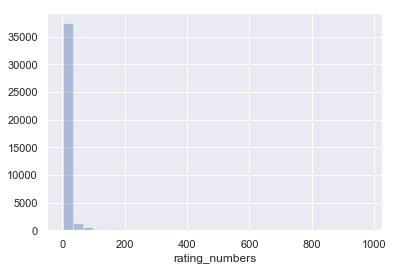

In [13]:
# Let's visualize this
sns.distplot(reviews_stats['rating_numbers'], bins=30, kde=False)
plt.show()

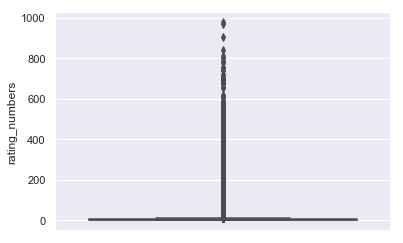

In [14]:
ax = sns.boxplot( y="rating_numbers", data=reviews_stats)

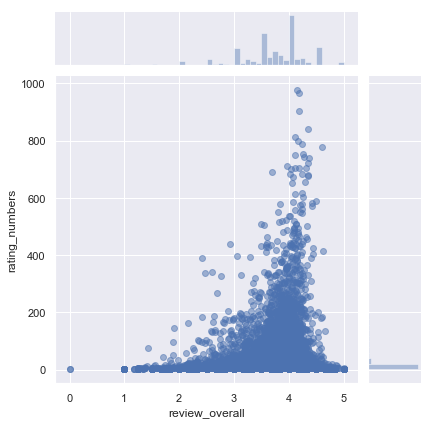

In [15]:
sns.jointplot(x='review_overall', y='rating_numbers', data=reviews_stats, alpha=0.5)
plt.show()

#### Observations:
1. Around 50% of distinct beers have received number of reviews less than or equal to 2.
2. We need a significant number of reviews received in order to create the model.
3. Mean number of ratings is around 12 because of some beers having received high number of ratings.
4. We can see the distribution is highly skewed.

In order to create the model we would need beers having atleast N reviews. We don't want beers with very few reviews. 
So, based on above plots we can choose beers having atleast 51 reviews, so that it can predict better. Ratings are very well spread across all values for number of reviews > 51.
We would consider all beers which have received reviews >= 51. This is approximately 5% of the total number of beers(40304).

In [16]:
# Taking rating_numbers >= 51
reviews_stats = reviews_stats[reviews_stats['rating_numbers'] >= 51]
reviews_stats['rating_numbers'].describe()


count    2028.000000
mean      145.067554
std       122.624804
min        51.000000
25%        69.000000
50%       100.000000
75%       170.000000
max       977.000000
Name: rating_numbers, dtype: float64

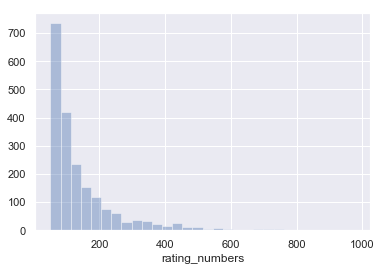

In [17]:
# Let's visualize this
sns.distplot(reviews_stats['rating_numbers'], bins=30, kde=False)
plt.show()

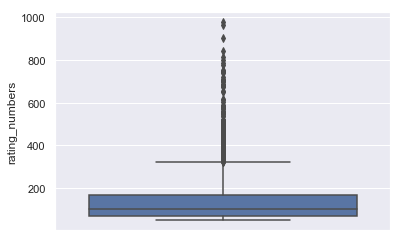

In [18]:
ax = sns.boxplot( y="rating_numbers", data=reviews_stats)

Now we are left with 2028/40304 beers. Approximately 5.03% of original count.

In [19]:
# Filtering the original dataframe 

df_beer = df_beer.loc[df_beer['beer_beerid'].isin(reviews_stats.index)]

In [20]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294197 entries, 12 to 475767
Data columns (total 3 columns):
beer_beerid           294197 non-null int64
review_profilename    294197 non-null object
review_overall        294197 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.0+ MB


In [21]:
# Getting unique count of each column.
df_beer.nunique()

beer_beerid            2028
review_profilename    19447
review_overall            9
dtype: int64

Observations:
1. Now we are left with 2028 distinct beers and 19447 distinct userids.
2. There are 9 distinct review ratings left.
3. Total number of records left = 294197.

In [22]:
# Let's group by user_id and count the number of reviews each user has written and see the mean distribution for it.

reviews_stats_user = pd.DataFrame(df_beer.groupby('review_profilename')['review_overall'].mean())
reviews_stats_user['rating_numbers'] = pd.DataFrame(df_beer.groupby('review_profilename')['review_overall'].count())

In [23]:
# Let's see the distribution of number of reviews
reviews_stats_user['rating_numbers'].describe([.1, .2, .3, .4, .5, .6, .7, .75, .8, .85, .9, .95])

count    19447.000000
mean        15.128143
std         36.208335
min          1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          2.000000
50%          3.000000
60%          4.000000
70%          7.000000
75%         10.000000
80%         15.000000
85%         24.000000
90%         40.000000
95%         76.000000
max        508.000000
Name: rating_numbers, dtype: float64

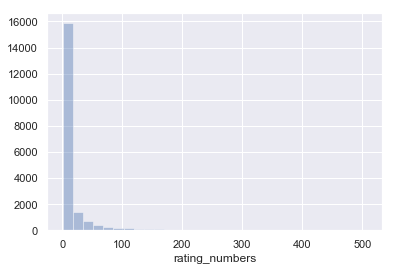

In [24]:
# Let's visualize this
sns.distplot(reviews_stats_user['rating_numbers'], bins=30, kde=False)
plt.show()

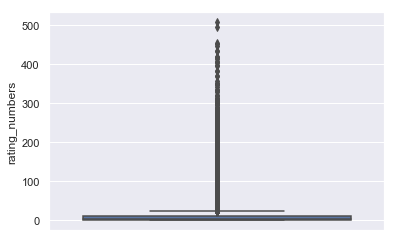

In [25]:
ax = sns.boxplot( y="rating_numbers", data=reviews_stats_user)

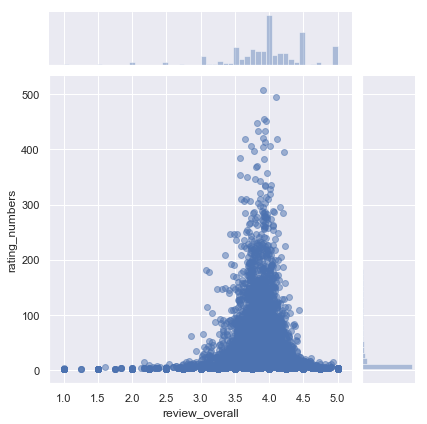

In [26]:
sns.jointplot(x='review_overall', y='rating_numbers', data=reviews_stats_user, alpha=0.5)
plt.show()

#### Observations:
1. Around 50% of distinct users have reviewed less than or equal to 3 times.
2. We need a significant number of reviews given by a user in order to create the model.
3. Mean number of reviews given is around 15 because of some users have given high number of reviews.
4. We can see the distribution is highly skewed.

We need to take only those users for which we have atleast a few ratings so that we can make recommendations. 
Based on above graphs we can take minimum number of reviews given a user to be considered = 24. For atleast 24 reviews the distribution is well spread across all values. This is approximately 15% of the total number of users(19447). We would consider all users which have received reviews >= 24.

In [27]:
# Taking counts >= 24
reviews_stats_user = reviews_stats_user[reviews_stats_user['rating_numbers'] >= 24]
reviews_stats_user['rating_numbers'].describe()

count    2936.000000
mean       76.485354
std        64.137447
min        24.000000
25%        34.000000
50%        53.000000
75%        93.000000
max       508.000000
Name: rating_numbers, dtype: float64

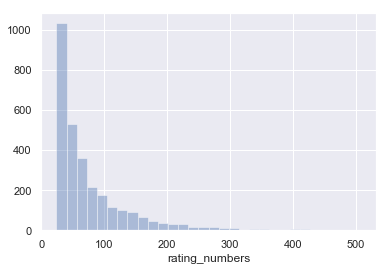

In [28]:
# Let's visualize this
sns.distplot(reviews_stats_user['rating_numbers'], bins=30, kde=False)
plt.show()

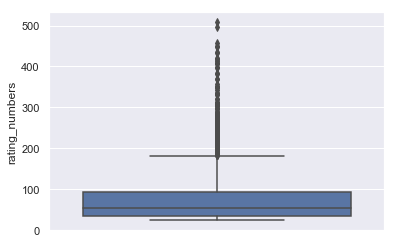

In [29]:
ax = sns.boxplot( y="rating_numbers", data=reviews_stats_user)

Now we are left with 2936/19447 distinct users. Approximately 15.1% of original count.

In [30]:
# Filtering the original dataframe 

df_beer = df_beer.loc[df_beer['review_profilename'].isin(reviews_stats_user.index)]

In [31]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 224561 entries, 12 to 475767
Data columns (total 3 columns):
beer_beerid           224561 non-null int64
review_profilename    224561 non-null object
review_overall        224561 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.9+ MB


In [32]:
# Getting unique count of each column.
df_beer.nunique()

beer_beerid           2028
review_profilename    2936
review_overall           9
dtype: int64

Observations:
1. Now we are left with 2028 distinct beers and 2936 distinct userids.
2. There are 9 distinct review ratings left.
3. Total number of records left = 224561.

## Data Exploration

#### Getting distinct values of ratings:

In [33]:
# Initially we had 10 distinct ratings. After Data Preparation we are left with following 9 ratings. 0 ratings are removed.
print(sorted(df_beer['review_overall'].unique()))

[1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


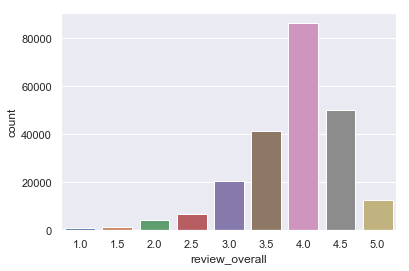

In [34]:
# Visualizing the counts
sns.countplot(x="review_overall", data=df_beer)
plt.show()

#### Visualizing average beer ratings:

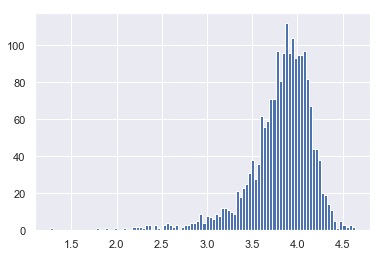

In [35]:
avg_beer_ratings = pd.DataFrame(df_beer.groupby('beer_beerid')['review_overall'].mean())
plt.hist(avg_beer_ratings['review_overall'], bins=100)
plt.show()

In [36]:
avg_beer_ratings.review_overall.mean()

3.807962870059009

#### Observations: 
Most of the beers are rated between 3-4.5 on an average and avg. rating ~ 3.81.

#### Visualizing average user ratings:

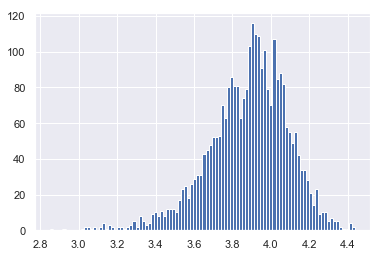

In [37]:
avg_user_ratings = pd.DataFrame(df_beer.groupby('review_profilename')['review_overall'].mean())
plt.hist(avg_user_ratings['review_overall'], bins=100)
plt.show()

In [38]:
avg_user_ratings.review_overall.mean()

3.8799610517279204

#### Observations: 
Most users tend to rate the beer between 3.2-4.4 on an average and avg_user rating ~ 3.88.

#### Visaulizing the average number of ratings given to the beers.

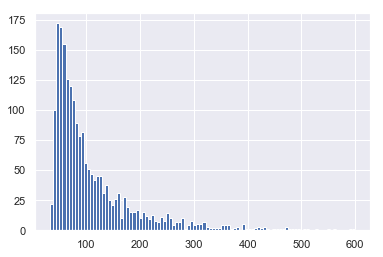

In [39]:
num_beer_reviews = pd.DataFrame(df_beer.groupby('beer_beerid')['review_overall'].count())
plt.hist(num_beer_reviews['review_overall'], bins=100)
plt.show()

Observation : This is similar to the plot we created above while identifying N. We can see that high number of beers have number of reviews between 50-200.

####  Visaulizing the average number of ratings given by the users.

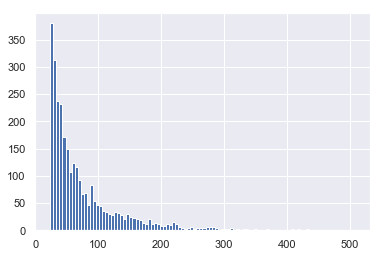

In [40]:
num_user_reviews = pd.DataFrame(df_beer.groupby('review_profilename')['review_overall'].count())
plt.hist(num_user_reviews['review_overall'], bins=100)
plt.show()

Observation : This is similar to the plot we created above while we chose the optimum number of user ratings to be taken. We can see that high number of users have given number of rating between 25-200.

In [41]:
# Resetting the indexes after removing records.
df_beer.reset_index(inplace=True, drop=True)

df_beer.shape

(224561, 3)

## Recommendation Models

### Dividing the dataset into train and test

First we would do user based recommendation than item based recommendation

In [42]:
# Creating test train splits.
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_beer, test_size=0.30, random_state=40)

In [43]:
print(train.shape)
print(test.shape)

(157192, 3)
(67369, 3)


### User Based Recommendation

In [44]:
# pivot beer ratings into beer features
df_beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

# Printing the shape of dataframe
print(df_beer_features.shape)

df_beer_features.head()

(2936, 2028)


beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Copy train and test dataset
These dataset will be used for prediction and evaluation. 
- Dummy train will be used later for prediction of the beers which has not been rated by the user. To ignore the beers rated by the user, we will mark it as 0 during prediction. The beers not rated by user is marked as 1 for prediction. 
- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the beers rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [45]:
dummy_train = train.copy()
dummy_test = test.copy()

In [46]:
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [47]:
# The beers not rated by user is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers not rated by user is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [48]:
dummy_train.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100floods,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1759Girl,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1fastz28,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [49]:
dummy_test.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


#### Using Cosine Similarity

In [50]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_beer_features, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1.         0.         0.         ... 0.         0.03995561 0.        ]
 [0.         1.         0.05127674 ... 0.03533718 0.09612698 0.        ]
 [0.         0.05127674 1.         ... 0.         0.07265033 0.        ]
 ...
 [0.         0.03533718 0.         ... 1.         0.         0.        ]
 [0.03995561 0.09612698 0.07265033 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [51]:
user_correlation.shape

(2936, 2936)

#### Using adjusted Cosine 

Here, not removing the NaN values and calculating the mean only for the beers rated by the user

In [52]:
beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

beer_features.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,3.5,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the rating of the beer for each user aroung 0 mean

In [53]:
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

df_subtracted.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1fastz28,NaN,-0.410448,NaN,0.089552,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding cosine similarity

In [54]:
# User Similarity Matrix
user_correlation = 1.0 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.          0.          0.         ...  0.          0.00423187
   0.        ]
 [ 0.          1.         -0.00548088 ... -0.03048806  0.03536375
   0.        ]
 [ 0.         -0.00548088  1.         ...  0.          0.00380848
   0.        ]
 ...
 [ 0.         -0.03048806  0.         ...  1.          0.
   0.        ]
 [ 0.00423187  0.03536375  0.00380848 ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


### Prediction

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [55]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.        , 0.00423187,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.03536375,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.00380848,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.00423187, 0.03536375, 0.00380848, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

Rating predicted by the user (for beers rated as well as not rated) is the weighted sum of correlation with the beer rating (as present in the rating dataset). 

In [56]:
user_predicted_ratings = np.dot(user_correlation, beer_features.fillna(0))
user_predicted_ratings

array([[0.54512747, 1.87686679, 1.89416409, ..., 0.41906563, 3.3294939 ,
        1.29489479],
       [2.21965744, 4.50005124, 3.05025511, ..., 1.62368332, 5.59678859,
        3.18654478],
       [0.37139808, 1.86893812, 0.76449358, ..., 1.07456329, 1.27878193,
        1.11446562],
       ...,
       [4.33243057, 9.32276888, 8.03688418, ..., 3.72169353, 3.91195418,
        2.7112977 ],
       [2.47899878, 7.21259499, 3.89311121, ..., 2.49074345, 4.50803765,
        2.40396679],
       [2.83180404, 4.7805516 , 4.39997863, ..., 0.69172993, 2.16132892,
        1.73000308]])

In [57]:
user_predicted_ratings.shape

(2936, 2028)

Since we are interested only in the beers not rated by the user, we will ignore the beers rated by the user by making it zero. 

In [58]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.545127,1.876867,1.894164,2.069622,0.285340,0.583800,2.355692,1.408548,7.238795,2.709046,...,0.895309,2.041688,4.111709,1.591550,0.228248,0.318341,0.463136,0.419066,3.329494,1.294895
05Harley,2.219657,4.500051,3.050255,5.314040,0.846822,1.602969,3.326802,1.979786,9.228832,5.299144,...,2.164857,3.526223,7.408061,0.853167,0.499701,2.003223,2.212483,1.623683,5.596789,3.186545
100floods,0.371398,1.868938,0.764494,2.335213,0.551755,0.636664,1.607724,0.999514,4.629827,3.602200,...,0.249800,0.455640,2.455481,0.497214,1.267249,0.638537,1.224463,1.074563,1.278782,1.114466
1759Girl,3.456786,6.079848,3.810684,5.960914,0.727760,0.797255,3.910406,3.091209,13.289385,12.312925,...,1.068464,2.729279,5.093816,1.414110,1.767874,1.776554,1.428777,1.790073,3.636413,2.018674
1fastz28,4.673565,0.000000,4.608767,0.000000,2.502237,2.303899,6.854866,5.906428,15.945582,10.828255,...,1.419654,1.358074,5.032394,1.755833,1.090310,1.286546,2.140551,1.688403,3.134239,3.291982


### Finding co-relation between first 10 users

In [59]:
top_users = user_correlation[:10, :10]
top_users_list = list(beer_features.index[:10])
top_users_list

['0110x011',
 '05Harley',
 '100floods',
 '1759Girl',
 '1fastz28',
 '32hoss32',
 '3Vandoo',
 '4000qtrap',
 '4DAloveofSTOUT',
 '51mmz0rz']

In [60]:
# Creating a dataframe using above matrix and list of indexes
top_users_df = pd.DataFrame(top_users, columns=top_users_list, index =top_users_list )

In [61]:
# Plotting co-relation matrix

corr = top_users_df.corr()
corr.style.background_gradient(cmap="YlGnBu")

,0110x011,05Harley,100floods,1759Girl,1fastz28,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz
0110x011,1,-0.119301,-0.121956,-0.115985,-0.122369,-0.117069,-0.119346,-0.114095,-0.117739,-0.101632
05Harley,-0.119301,1,-0.128644,-0.0938335,-0.127551,-0.123483,-0.125906,-0.120141,-0.0288542,-0.120183
100floods,-0.121956,-0.128644,1,-0.124666,-0.0593097,-0.124867,-0.0242862,-0.122843,-0.127072,-0.122616
1759Girl,-0.115985,-0.0938335,-0.124666,1,-0.0987412,-0.119561,-0.122276,-0.106889,-0.120176,-0.116756
1fastz28,-0.122369,-0.127551,-0.0593097,-0.0987412,1,-0.038866,-0.103993,-0.110283,-0.133036,-0.107775
32hoss32,-0.117069,-0.123483,-0.124867,-0.119561,-0.038866,1,-0.123105,-0.117866,-0.122004,-0.117639
3Vandoo,-0.119346,-0.125906,-0.0242862,-0.122276,-0.103993,-0.123105,1,-0.120351,-0.124294,-0.120154
4000qtrap,-0.114095,-0.120141,-0.122843,-0.106889,-0.110283,-0.117866,-0.120351,1,-0.111142,-0.114899
4DAloveofSTOUT,-0.117739,-0.0288542,-0.127072,-0.120176,-0.133036,-0.122004,-0.124294,-0.111142,1,-0.118634
51mmz0rz,-0.101632,-0.120183,-0.122616,-0.116756,-0.107775,-0.117639,-0.120154,-0.114899,-0.118634,1


Observation: There isnt much co-relation between first 10 users.

### Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different beer ID. In the user based similarity, we had taken mean for each user instead of each beer. 

In [62]:
beer_features = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

beer_features.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1fastz28,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz,...,zerk,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# Normalising the beer rating for each beer
mean = np.nanmean(beer_features, axis=1)
df_subtracted = (beer_features.T-mean).T

In [64]:
df_subtracted.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1fastz28,32hoss32,3Vandoo,4000qtrap,4DAloveofSTOUT,51mmz0rz,...,zerk,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,-0.220930,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.257732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,0.131783,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity. Note that since the data is normalised, both the cosine metric and correlation metric will give the same value. 

In [65]:
# User Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00 -1.26793663e-02  5.18128378e-02 ... -7.67196988e-04
   2.76357182e-02 -2.43744596e-03]
 [-1.26793663e-02  1.00000000e+00 -1.75384992e-02 ... -5.00114139e-04
   0.00000000e+00 -5.61485257e-02]
 [ 5.18128378e-02 -1.75384992e-02  1.00000000e+00 ...  7.29273096e-03
   6.29423478e-03  3.69455048e-02]
 ...
 [-7.67196988e-04 -5.00114139e-04  7.29273096e-03 ...  1.00000000e+00
   0.00000000e+00  2.98784922e-02]
 [ 2.76357182e-02  0.00000000e+00  6.29423478e-03 ...  0.00000000e+00
   1.00000000e+00 -1.12487987e-02]
 [-2.43744596e-03 -5.61485257e-02  3.69455048e-02 ...  2.98784922e-02
  -1.12487987e-02  1.00000000e+00]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [66]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1.        , 0.        , 0.05181284, ..., 0.        , 0.02763572,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05181284, 0.        , 1.        , ..., 0.00729273, 0.00629423,
        0.0369455 ],
       ...,
       [0.        , 0.        , 0.00729273, ..., 1.        , 0.        ,
        0.02987849],
       [0.02763572, 0.        , 0.00629423, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.0369455 , ..., 0.02987849, 0.        ,
        1.        ]])

#### Prediction

In [67]:
item_predicted_ratings = np.dot((beer_features.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.37291098, 0.42808107, 0.61618473, ..., 0.39224231, 0.8415823 ,
        0.85982094],
       [0.29315783, 0.84927171, 1.07639914, ..., 0.54134954, 0.74186316,
        0.58564245],
       [0.98761698, 0.51971505, 1.05157554, ..., 0.85899046, 1.27039586,
        0.81265396],
       ...,
       [2.30599267, 1.61016483, 2.09032738, ..., 1.24464604, 0.66210859,
        1.29908367],
       [1.60069032, 1.81407361, 2.21001713, ..., 1.09629556, 1.30503268,
        1.22866679],
       [0.51911134, 0.5707666 , 0.64135352, ..., 0.19932714, 0.44682442,
        0.77657316]])

In [68]:
item_predicted_ratings.shape

(2936, 2028)

In [69]:
dummy_train.shape

(2936, 2028)

#### Filtering the rating only for the beers not rated by the user for recommendation

In [70]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.372911,0.428081,0.616185,0.498452,0.664023,0.513453,0.257512,0.487308,2.164645,1.074082,...,2.033690,0.808722,1.365216,0.287301,0.941412,0.872489,0.351191,0.392242,0.841582,0.859821
05Harley,0.293158,0.849272,1.076399,1.172139,0.880656,1.347390,0.737357,0.940340,2.089108,1.078556,...,0.642015,0.831744,1.456584,0.892119,0.175044,1.148764,0.768224,0.541350,0.741863,0.585642
100floods,0.987617,0.519715,1.051576,0.600898,0.245642,1.084412,1.441544,0.736519,2.417536,1.323712,...,0.297673,0.713920,0.593214,1.087315,0.748956,0.927105,0.759202,0.858990,1.270396,0.812654
1759Girl,1.475384,0.477249,1.601919,1.063959,1.134887,0.824852,1.768054,0.264807,1.751364,0.550420,...,0.497129,0.438727,0.975784,1.279198,0.924855,0.442419,0.734888,0.853378,0.425049,0.901600
1fastz28,4.887399,0.000000,3.894895,0.000000,3.648424,3.364486,3.377534,2.845374,3.921059,3.727352,...,1.612968,1.906697,2.007426,1.932500,2.054216,1.763594,1.493386,1.489240,2.917088,1.864875


### Finding co-relation between first 10 users

In [71]:
top_beers = item_correlation[:10, :10]
top_beers_list = list(beer_features.index[:10])
top_beers_list

[5, 6, 7, 10, 14, 15, 17, 19, 30, 31]

In [72]:
# Creating a dataframe using above matrix and list of indexes 
top_beers_df = pd.DataFrame(top_beers, columns=top_beers_list, index =top_beers_list )

In [73]:
# Plotting co-relation matrix

corr = top_beers_df.corr()
corr.style.background_gradient(cmap="YlGnBu")

,5,6,7,10,14,15,17,19,30,31
5,1,-0.132019,-0.0114506,-0.140086,-0.154914,-0.161212,-0.13566,-0.131306,-0.132931,-0.108818
6,-0.132019,1,-0.1314,-0.0909589,-0.0670986,-0.0913132,-0.132288,-0.133475,-0.130391,-0.14622
7,-0.0114506,-0.1314,1,-0.108742,-0.153915,-0.161902,-0.135989,-0.131163,-0.132867,-0.143909
10,-0.140086,-0.0909589,-0.108742,1,-0.0644397,-0.0914889,-0.112317,-0.102616,-0.111768,-0.154414
14,-0.154914,-0.0670986,-0.153915,-0.0644397,1,0.0512395,-0.140131,-0.0727919,-0.0728604,-0.162647
15,-0.161212,-0.0913132,-0.161902,-0.0914889,0.0512395,1,-0.0749422,-0.159095,-0.093649,0.0182394
17,-0.13566,-0.132288,-0.135989,-0.112317,-0.140131,-0.0749422,1,-0.101879,-0.138763,-0.0425499
19,-0.131306,-0.133475,-0.131163,-0.102616,-0.0727919,-0.159095,-0.101879,1,-0.134538,-0.0975828
30,-0.132931,-0.130391,-0.132867,-0.111768,-0.0728604,-0.093649,-0.138763,-0.134538,1,-0.0941818
31,-0.108818,-0.14622,-0.143909,-0.154414,-0.162647,0.0182394,-0.0425499,-0.0975828,-0.0941818,1


Observation: There is very less co-relation among first 10 beers.

### Evaluation

Evaluation will be same as we have seen above for the prediction. The only difference being, we would evaluate for the beer already rated by the user insead of predicting it for the beer not rated by the user. 

#### Using User Similarity

In [74]:
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)
mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

# User Similarity Matrix
test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.00204252 ... 0.         0.         0.        ]
 [0.         0.00204252 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


In [75]:
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, test_beer_features.fillna(0))
test_user_predicted_ratings

array([[0.        , 0.71003498, 0.14019804, ..., 0.07272433, 0.67266557,
        0.15391425],
       [0.        , 0.39480418, 0.69544922, ..., 0.05281819, 0.44162009,
        0.36488834],
       [0.3415747 , 0.24260738, 0.55829356, ..., 0.        , 0.61913376,
        1.01759282],
       ...,
       [0.28239174, 1.84207442, 1.56870338, ..., 0.43112603, 0.55563754,
        0.17305097],
       [0.5166354 , 1.1817433 , 1.36712047, ..., 0.24411048, 0.62523433,
        0.17298813],
       [0.89303895, 2.35202034, 1.12192906, ..., 0.30748989, 0.25328376,
        0.10085667]])

#### Doing prediction for the beer rated by the user

In [76]:
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [77]:
test_user_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.002528,0.0,0.0,0.0,0.0,0.0


#### Calculating the RMSE for only the beers rated by user. For  RMSE, normalising the rating to (1,5) range. 

In [78]:
X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [79]:
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [80]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [81]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.774788920111984


#### Using Item similarity

In [82]:
test_beer_features = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(test_beer_features, axis=1)
test_df_subtracted = (test_beer_features.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
test_item_correlation[test_item_correlation<0]=0

In [83]:
test_item_correlation.shape

(2028, 2028)

In [84]:
test_beer_features.shape

(2028, 2936)

In [85]:
test_item_predicted_ratings = (np.dot(test_item_correlation, test_beer_features.fillna(0))).T
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)
test_item_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,...,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1759Girl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1fastz28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.084946,0.0,0.0,0.0,0.0,0.0


In [86]:
#### Calculating the RMSE value for item based

In [87]:
X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))


test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

MinMaxScaler(copy=True, feature_range=(1, 5))


In [88]:
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.087198050848183


### Observations & Conclusions:
1. We are getting RMSE value ~ 1.774 for User Based Recommendation system.
2. We are getting RMSE value ~ 2.087 for Item based Recommendation system.

So, we would use User based recommendation system as it is having less RMSE hence better at predicting recommendations.

### Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the model

#### For userid = cokes

In [89]:
# user based model recommendation
user_final_rating.loc['cokes'].sort_values(ascending=False)[0:5]

beer_beerid
412     40.363336
276     38.893851
34      35.500900
1904    34.778834
4083    34.285060
Name: cokes, dtype: float64

#### So, top 5 user based recommended beers for userid = cokes are beers = 412, 276, 34, 1904, 4083.

In [90]:
# item based model recommendation
item_final_rating.loc['cokes'].sort_values(ascending=False)[0:5]

beer_beerid
2147     13.664619
21363    13.475804
8116     13.420274
34363    13.406703
46749    13.026569
Name: cokes, dtype: float64

#### So, top 5 item based recommended beers for userid = cokes are beers = 2147, 21363, 8116, 34363, 46749.

#### For userid = genog

In [91]:
# user based model recommendation
user_final_rating.loc['genog'].sort_values(ascending=False)[0:5]

beer_beerid
1904    34.117497
2093    34.019984
1093    33.957436
412     33.543892
4083    32.322719
Name: genog, dtype: float64

#### So, top 5 user based recommended beers for userid = genog are beers = 1904, 2093, 1093, 412, 4083.

In [92]:
# item based model recommendation
item_final_rating.loc['genog'].sort_values(ascending=False)[0:5]

beer_beerid
21363    6.248602
46749    6.104930
34363    5.678770
33467    5.506348
39873    5.367307
Name: genog, dtype: float64

#### So, top 5 item based recommended beers for userid = genog are beers = 21363, 46749, 34363, 33467, 39873.

#### For userid = giblet

In [93]:
# user based model recommendation
user_final_rating.loc['giblet'].sort_values(ascending=False)[0:5]

beer_beerid
1904    41.734141
412     37.415177
276     36.881111
2093    36.125715
355     35.600116
Name: giblet, dtype: float64

#### So, top 5 user based recommended beers for userid = giblet are beers = 1904, 412, 276, 2093, 355.

In [94]:
# item based model recommendation
item_final_rating.loc['giblet'].sort_values(ascending=False)[0:5]

beer_beerid
9584     4.538399
27842    4.493149
6590     4.437567
9365     4.362919
22387    4.250933
Name: giblet, dtype: float64

#### So, top 5 item based recommended beers for userid = giblet are beers = 9584, 27842, 6590, 9365, 22387.

### Observation and Conclusions:

1. We would prefer user based recommendation model as it is having lower RMSE.
2. User based recommender system is giving similar results for above 3 users.
3. Item based system is giving different sets of results and is not able to identify similarity of taste for above users like the user based system. 